In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from spherex_emu.emulator import pk_emulator
from spherex_emu.dataset import pk_galaxy_dataset
from spherex_emu.utils import load_config_file, calc_avg_loss, symmetric_log, normalize

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 11})
plt.rcParams["legend.frameon"] = False

In [45]:
def chi_squared(prediction, target):

    return np.sum((prediction - target)**2 / target)

In [20]:
# load the network
emulator_dir = "/home/joeadamo/Research/SPHEREx/spherex_emu/emulators/mlp_single_tracer/"
#config_file = "/home/joeadamo/Research/SPHEREx/spherex_emu/configs/network_pars_single_tracer_single_redshift.yaml"
config_dict = load_config_file(emulator_dir+"config.yaml")
k = np.linspace(0.01, 0.25, 25)

emulator = pk_emulator(emulator_dir+"config.yaml")
emulator.load_trained_model()

In [21]:
# load the test dataset
test_data = emulator._load_data("testing", 1., False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config_dict["batch_size"], shuffle=True)

Best training loss   = 0.0035
Best validation loss = 0.0035
Average test loss    = 0.0031


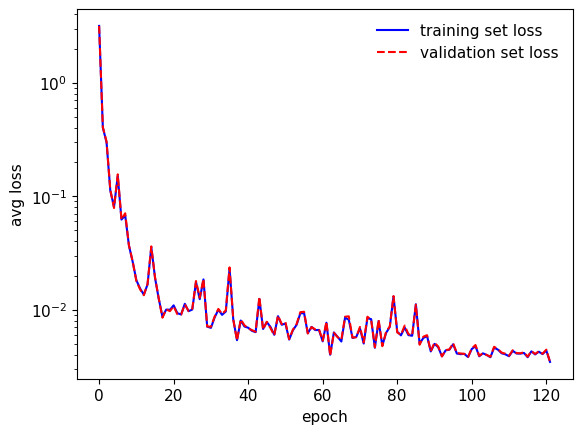

In [29]:
training_data = torch.load(emulator_dir+"train_data.dat")

epochs = range(training_data.shape[1])
train_loss = training_data[0,:]
valid_loss = training_data[1,:]
test_loss = calc_avg_loss(emulator.model, test_loader)

print("Best training loss   = {:0.4f}".format(torch.amin(train_loss)))
print("Best validation loss = {:0.4f}".format(torch.amin(valid_loss)))
print("Average test loss    = {:0.4f}".format(test_loss))

plt.plot(epochs, train_loss, c="blue", label="training set loss")
plt.plot(epochs, valid_loss, c="red", ls="--", label="validation set loss")
plt.xlabel("epoch")
plt.ylabel("avg loss")
plt.yscale("log")
plt.legend()

In [23]:
# pk_true = np.zeros((len(test_data), 1, 1, 2, 25))
# pk_emu = np.zeros((len(test_data), 1, 1, 2, 25))
# params_neg = []
# idx_neg = []
# for i in tqdm(range(len(test_data))):
#     params = test_data[i][0].detach().numpy()
#     pk_true[i] = test_data.get_power_spectra(i)
#     pk_emu[i] = emulator.get_power_spectra(params)
#     if np.any(pk_true[i,0,0,0,:] < 0):
#         params_neg.append(test_data[i][0].detach().numpy())
#         idx_neg.append(i)
# params_neg = np.array(params_neg)

# fig, ax = plt.subplots(1, 2, figsize=(9,5))
# for i in range(len(test_data)):
#     ax[0].plot(k, pk_true[i,0,0,0,:], c="red", lw=0.1, alpha=0.2)
#     ax[1].plot(k, pk_true[i,0,0,1,:], c="red", lw=0.1, alpha=0.2)

# print(np.amax(pk_true), np.amin(pk_true))

# ax[0].axhline(0, c="black", ls="--")
# ax[1].axhline(0, c="black", ls="--")

# ax[0].set_xlabel("k")
# ax[1].set_xlabel("k")
# #plt.ylim(-10000, 0)

In [63]:
pk_error = []
error_per_bin = np.zeros((2, 25))
chi2 = np.zeros(len(test_data))

for i in tqdm(range(len(test_data))):

    params = test_data[i][0].detach().numpy()

    pk_true = test_data.get_power_spectra(i)
    pk_pred = emulator.get_power_spectra(params)

    chi2[i] = chi_squared(pk_pred, pk_true)
    #pk_true = normalize(pk_true, config_dict["min_norm_v"], config_dict["max_norm_v"])
    #pk_pred = normalize(pk_pred, config_dict["min_norm_v"], config_dict["max_norm_v"])
    if np.any(pk_true < 0) == False:
        pk_error.append((pk_pred - pk_true) / pk_true)

pk_error = np.array(pk_error)
print(pk_error.shape)

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3704.59it/s]

(7750, 1, 1, 2, 25)


Average of chi squared test = 2338.11
Average errror per bin = 8.17%


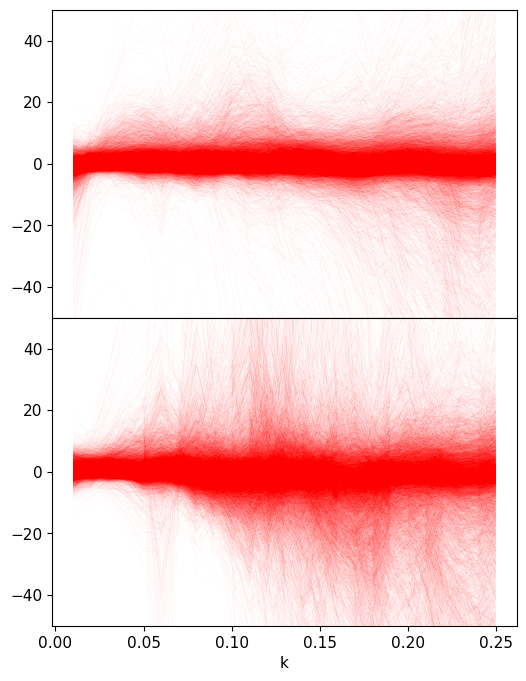

In [66]:
error_mean = 100*np.mean(abs(pk_error), axis=0)
error_std = 100*np.std(pk_error, axis=0)
print("Average of chi squared test = {:0.2f}".format(np.mean(chi2)))
print("Average errror per bin = {:0.2f}%".format(100*np.mean(abs(pk_error))))
fig, ax = plt.subplots(2, 1, figsize=(6,8), sharex=True)
for i in range(len(pk_error)):
   ax[0].plot(k, 100*pk_error[i,0,0,0,:], c="red", lw=0.1, alpha=0.1)
   ax[1].plot(k, 100*pk_error[i,0,0,1,:], c="red", lw=0.1, alpha=0.1)

# ax[0].plot(k, error_mean[0,0,0,:], c="black")
# ax[1].plot(k, error_mean[0,0,1,:], c="black")
ax[1].set_xlabel("k")
ax[0].set_ylim(-50, 50)
ax[1].set_ylim(-50, 50)
fig.subplots_adjust(hspace=0)

In [25]:
# pk_CLASS_PT = np.array([16820.05513766, 23946.48158473, 25453.02712092, 24037.92768727,
#                         21593.59444023, 19017.53002514, 16536.15764868, 14148.70189409,
#                         11847.34712271,  9675.37480162,  7698.56909414,  5957.1104404,
#                         4450.72807379,  3157.2194757,   2057.24458963,  1129.07015037,
#                         336.55155207,  -354.79329047,  -973.23837262, -1530.23765555,
#                        -2011.6919702,  -2406.67233749, -2721.42923145, -2966.09015841, -3155.87940414])

# pk_yosuke = test_data.get_power_spectra(idx_neg[0])

# plt.plot(k, pk_CLASS_PT)
# plt.plot(k, pk_yosuke[0,0,0,:])

## Test individual power spectra

8117
tensor([ 1.2185e-09, -2.5598e+01,  5.8042e-01,  1.5627e-01,  2.0561e+00])
(2, 25)


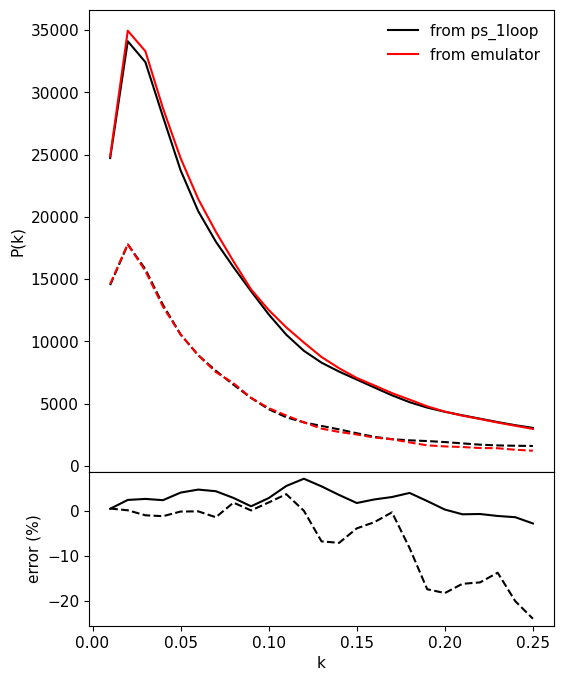

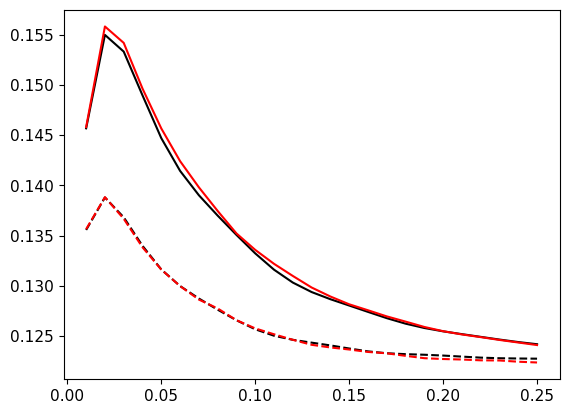

In [68]:
idx = np.random.randint(len(test_data))
#idx = 5756
temp = pk_error.reshape(-1, 2*25)
#idx = np.argmax(np.mean(temp, axis=1))
print(idx)

pk_true = test_data.get_power_spectra(idx)
params = test_data[idx][0]
print(params)
pk_emu = emulator.get_power_spectra(params.detach().numpy())
error = 100 * (pk_emu - pk_true) / pk_true

pk_raw = test_data[idx][1].view(2, len(k)).detach().numpy()
pk_emu_raw = emulator.model.forward(params.view(-1, len(params)))
pk_emu_raw = pk_emu_raw.view(2, len(k)).detach().numpy()
#error = 100 * (pk_emu_raw - pk_raw) / pk_raw
print(pk_emu_raw.shape)

fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(k, pk_true[0,0,0,:], c="black", label="from ps_1loop")
axs[0].plot(k, pk_emu[0,0,0,:], c="red", label="from emulator")
axs[0].plot(k, pk_true[0,0,1,:], c="black", ls="--")
axs[0].plot(k, pk_emu[0,0,1,:], c="red", ls="--")
axs[1].plot(k, error[0,0,0,:], c="black")
axs[1].plot(k, error[0,0,1,:], c="black", ls="--")

axs[1].set_xlabel("k")
axs[0].set_ylabel("P(k)")
axs[1].set_ylabel("error (%)")
axs[0].legend()
fig.subplots_adjust(hspace=0)

plt.figure()
plt.plot(k, pk_raw[0,:], c="black", label="from ps_1loop")
plt.plot(k, pk_emu_raw[0,:], c="red", label="from emulator")
plt.plot(k, pk_raw[1,:], c="black", ls="--")
plt.plot(k, pk_emu_raw[1,:], c="red", ls="--")

In [27]:
test = torch.Tensor([1])

print(test.item())
print(list(test.tolist()))

1.0
[1.0]
